# Predicting Comment Score

In [57]:
import pandas as pd; import numpy as np; 
from scipy.sparse import csr_matrix
import nltk
import math; import time
# import enchant; english_dict = enchant.Dict("en_US")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
#from html.parser import HTMLParser
from sklearn.cross_validation import StratifiedKFold
from sklearn import linear_model
from sklearn import metrics
# from stemming.porter2 import stem
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, \
                             stop_words = None, max_features = 5000) 

import seaborn
import matplotlib
from matplotlib import pyplot as plt
#from matplotlib import pylab
%matplotlib inline
#%pylab inline
#pylab.rcParams['figure.figsize'] = (20, 5)

# Tsne
from sklearn import manifold

In [58]:
font = {'weight' : 'normal',
        'size'   : 22}

axes = {'titlesize'  : 22,
        'labelsize'  : 22}

legend = {'fontsize'  : 22}

figure = {'figsize'  : (10,5)}

matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rc('legend', **legend)
matplotlib.rc('figure', **figure)

## 1 Data

### 1.1 Import cleaned comments

In [5]:
dftrain = pd.read_csv("data/finalnostop.csv")

In [6]:
#dft_pic = dftrain[dftrain.subreddit=="pics"]
dft_wne = dftrain[dftrain.subreddit=="worldnews"]
#dft_fun = dftrain[dftrain.subreddit=="funny"]
dft_aww = dftrain[dftrain.subreddit=="aww"]
#dft_gof = dftrain[dftrain.subreddit=="GlobalOffensive"]
dft_nba = dftrain[dftrain.subreddit=="nba"]
#dft_cje = dftrain[dftrain.subreddit=="circlejerk"]
#dft_all = [dft_pic, dft_nba, dft_wne, dft_fun, dft_aww, dft_gof, dft_cje]


#dft_all_BOW = [dft_pic_BOW, dft_nba_BOW, dft_wne_BOW, dft_fun_BOW, dft_aww_BOW, dft_gof_BOW, dft_cje_BOW]
#dft_all_TFI = [dft_pic_TFI, dft_nba_TFI, dft_wne_TFI, dft_fun_TFI, dft_aww_TFI, dft_gof_TFI, dft_cje_TFI]

### 1.2 Extract features

In [7]:
dft = dft_nba

In [8]:
# remove nans
def remove_nan(s):
    try:
        f = float(s)
        if math.isnan(f):
            return ""
    except:
        return s
sentences = []
for row in dft['body']:
    sentences.append(remove_nan(row)) 

In [9]:
print(remove_nan(str(float('nan'))))

In [86]:
dft.head()

,Unnamed: 0,Unnamed: 0.1,body,created_utc,score,link,subreddit
2,2,2,bruh,1456791980,1,http://reddit.com/r/nba/comments/48dhcw/c/d0iqq9r,nba
3,3,3,go http ftve akamaihd net hls live room k prog u,1459383579,1,http://reddit.com/r/nba/comments/4cnbpg/c/d1jt5ev,nba
5,5,5,kobe attempts year jason williams attempts yeesh,1459209968,1,http://reddit.com/r/nba/comments/4cbvvd/c/d1h18q2,nba
14,14,14,sound kinda mean man,1458173823,3,http://reddit.com/r/nba/comments/4aq1y4/c/d12o9bg,nba
15,15,15,hawks hitting stride gonna tough,1458605459,2,http://reddit.com/r/nba/comments/4beteo/c/d18j7fu,nba


## number of features to use???

What values to use??
occurred in too many documents (max_df): don't need to worry about this one!
occurred in too few documents (min_df): 
were cut off by feature selection (max_features)



In [10]:
# bag of words
vectorizer_count = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None,
                                   stop_words = None, max_features = 5000) 
dft_BOW = vectorizer_count.fit_transform(sentences)
dft_BOW_a = dft_BOW.toarray()

In [11]:
# TF_IDF
vectorizer_tfid = TfidfVectorizer(analyzer = "word", tokenizer = None, preprocessor = None,
                                  stop_words = None, max_features = 5000) 
dft_TFI = vectorizer_tfid.fit_transform(sentences)
dft_TFI_a = dft_TFI.toarray()

# Visualize bag of words + tf_idf

In [13]:
print(dft_BOW_a.shape)
print(dft_TFI_a.shape)

(533931, 5000)
(533931, 5000)


To visualize, we need a smaller dataset than .5 million points. We can visualize what this data set looks like by taking a random sample of *200* points


http://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html#example-manifold-plot-compare-methods-py
http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [42]:
bow_small = dft_BOW_a[np.random.randint(low=0,high=dft_BOW_a.shape[0], size=5000), :]
tfi_small = dft_TFI_a[np.random.randint(low=0,high=dft_TFI_a.shape[0], size=5000), :]

# check to make sure (5000,5000)
print(bow_small.shape)

(5000, 5000)


(-20.885432393265358,
 18.691718373747733,
 -58.623813265645204,
 16.538080567619637)

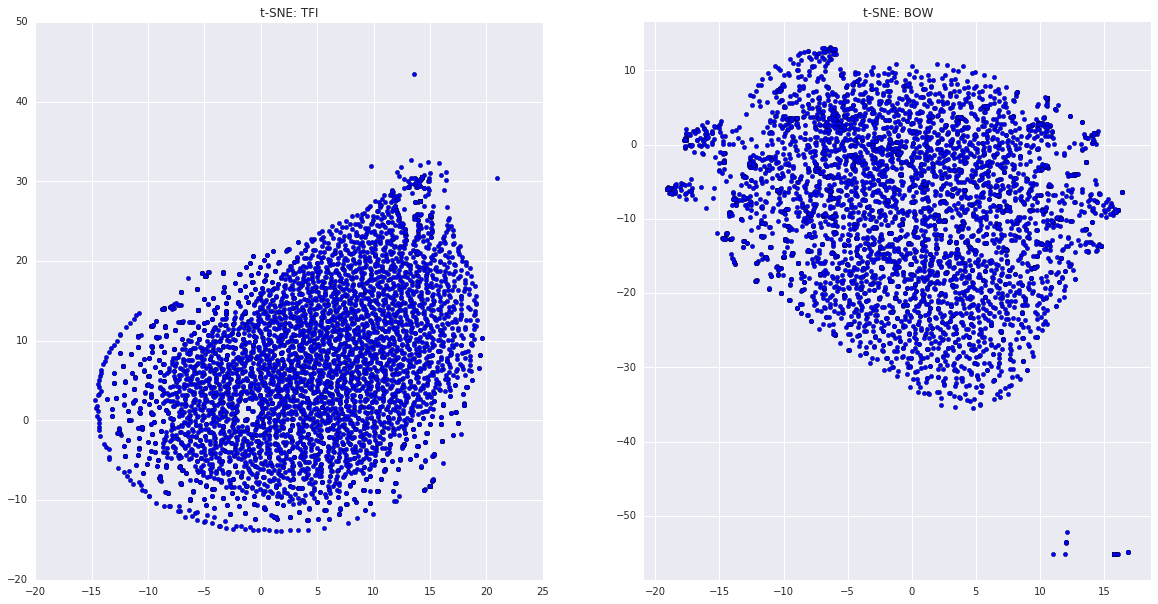

In [46]:
t0 = time.time()

# Perform TSNE
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
Y_tfi = tsne.fit_transform(tfi_small)
Y_bow = tsne.fit_transform(bow_small)

# Print out timing
t1 = time.time()
print("t-SNE: %.2g sec" % (t1 - t0))

# Generate plots
f,ax = plt.subplots(1,2,figsize = (20,10))
ax[0].scatter(Y_tfi[:, 0], Y_tfi[:, 1])#, cmap=plt.cm.Spectral)
ax[0].set_title("t-SNE: TFI")
ax[1].scatter(Y_bow[:, 0], Y_bow[:, 1])#, cmap=plt.cm.Spectral)
ax[1].set_title("t-SNE: BOW")
plt.axis('tight')

In [62]:
dft['score'].describe()

count    533931.000000
mean         10.576247
std          51.106897
min        -457.000000
25%           1.000000
50%           2.000000
75%           6.000000
max        4530.000000
Name: score, dtype: float64

In [70]:
dft['score'].mode()[0]

1

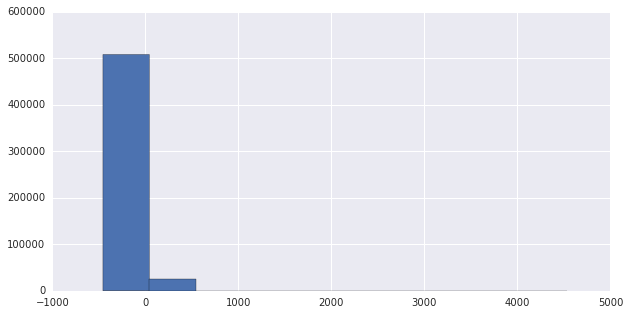

In [63]:
plt.hist(dft['score'])
plt.show()

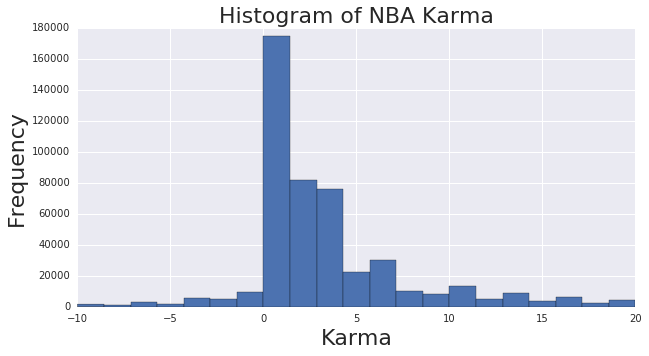

In [74]:
plt.hist(dft['score'],21,range=[-10, 20])
plt.title('Histogram of NBA Karma')
plt.xlabel('Karma')
plt.ylabel('Frequency')

# Clustering

## Regression

1. Remove points [0, 2]
2. TELL ANDREW TO RESCRAPE :((((
3. Types of regressions

Ridge, Lasso, RF regression, SVR, Linear
CV

Expect RF to be best b/c euclidian distance assumption doesn't work

In [87]:
# Remove points [0,2]
dft_small = dft[(dft['score']<0) | (dft['score']> 2)]

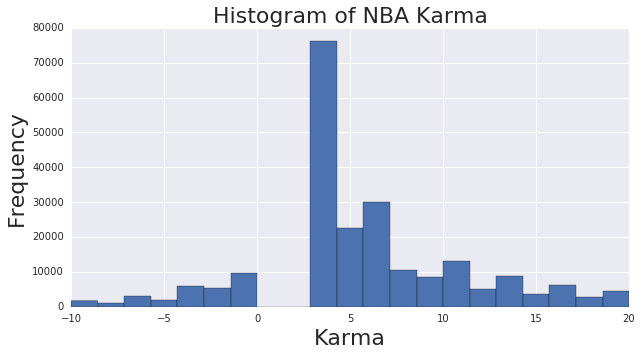

In [88]:
plt.hist(dft_small['score'],21,range=[-10, 20])
plt.title('Histogram of NBA Karma without [0,2]')
plt.xlabel('Karma')
plt.ylabel('Frequency')

# Classification

Note: we will set the following boundaries according to score:

Bad: < 0

Neutral: 0, 1

Good: 2, 3, 4, 5

Very Good: > 5

In [11]:
type(dft['score'])

pandas.core.series.Series

In [12]:
# categorize each comment by score
def categorize(score):
    if score<0:
        return 0
    if score==0 or score==1:
        return 1
    elif score==2 or score==3 or score==4 or score==5:
        return 2
    elif score>5:
        return 3
    else:
        return -1
labels = []
for row in dft['score']:
    labels.append(categorize(row)) 

In [ ]:
X_train = 

In [14]:
k=10
skf = StratifiedKFold(labels,n_folds=k, shuffle=True)

In [ ]:
print(np.shape(dft_BOW_a))

In [ ]:
#hyperparameters (fine-tuned graphically)
nNeighbors = 10 #KNN
maxLearners = 100 #RF
maxDepth = 10 #RF

mnb_avgErr = knn_avgErr = lsvc_avgErr = dt_avgErr = rf_avgErr = 0
mnb_avgTime = knn_avgTime = lsvc_avgTime = dt_avgTime = rf_avgTime = 0

for train_index, test_index in skf:
    X_train, X_test = dft_BOW_a[train_index], dft_BOW_a[test_index]
    Y_train, Y_test = labels[train_index], labels[test_index]
   
    # Multinomial Naive Bayes
    mnb = MultinomialNB()
    start_time = time.time()
    mnb.fit(X_train,Y_train)
    mnb_avgErr += (1/k) * zero_one_loss(mnb.predict(X_test,Y_test))
    mnb_avgTime += (1/k) * (time.time() - start_time)
    
    # K Nearest Neighbors
    knn = KNeighborsClassifier(n_neighbors=nNeighbors)
    start_time = time.time()
    knn.fit(X_train,Y_train)
    knn_avgErr += (1/k) * zero_one_loss(knn.predict(X_test),Y_test)
    knn_avgTime += (1/k) * (time.time() - start_time)

    # Linear Support Vector Classifier (Linear SVC)
    lsvc = LinearSVC()
    start_time = time.time()
    lsvc.fit(X_train,Y_train)
    lsvc_avgErr += (1/k) * zero_one_loss(lsvc.predict(X_test),Y_test)
    lsvc_avgTime += (1/k) * (time.time() - start_time)

    # Decision Tree
    dt = DecisionTreeClassifier()
    start_time = time.time()
    dt.fit(X_train,Y_train)
    dt_avgErr += (1/k) * zero_one_loss(dt.predict(X_test),Y_test)
    dt_avgTime += (1/k) * (time.time() - start_time)

    # Random Forest
    rf = RandomForestClassifier(n_estimators=maxLearners, max_depth = maxDepth, warm_start = False)
    start_time = time.time()
    rf.fit(X_train,Y_train)
    rf_avgErr += (1/k) * zero_one_loss(rf.predict(X_test),Y_test)
    rf_avgTime += (1/k) * (time.time() - start_time)    
    